# Let the presidents speak on economic matters

This is basically a copy of [NLP Zero to Hero](https://github.com/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%203%20-%20NLP/Course%203%20-%20Week%204%20-%20Lesson%202%20-%20Notebook.ipynb). The only change is that the inputs are not Irish lyrics, but the United States Presidents' writings in the Economic Report of the President from 1947 to 2020.

## Preprocess

I started from the pdf files I downloaded for the [tf-idf](https://github.com/mitsuoxv/erp/blob/master/README.md) and [sentiment analysis](https://github.com/mitsuoxv/erp/blob/master/Sentiment.md) in this repository. First, I made new pdf files which contain only the president parts by make_pres_pdf.py. Next, I extract texts into new files by make_pres_txt.py, which utilizes data_func.py I copied from [PDF Text Extraction in Python](https://towardsdatascience.com/pdf-text-extraction-in-python-5b6ab9e92dd).

Then I copied text files into 'texts/presidents/' directory, and manually cleaned up texts by:

1. correcting word order, where digitization made mistakes in shaping lines;

1. correcting words, where optical recognition made mistakes due to dirt, or the author apparently misspelled;

1. making punctuation common over reports, following my memory of ["The Mac is Not a Typewriter" by Robin P. Williams](https://www.goodreads.com/book/show/41600.The_Mac_is_Not_a_Typewriter), which I must have, but could not find now. As an exception, using minus mark instead of hyphen; and

1. changing lines, where I encounter ";", ":", "—" or "," and when I feel changed lines are natural if they were in President Johnson's reports.

I tried to be consistent over reports of different authors. Honestly, I am not sure whether "text" has become more consistent or not, as a result.

I download the texts from 'texts/presidents/' directory.

In [1]:
!pwd

/tf/notebooks


In [2]:
# !wget https://raw.githubusercontent.com/mitsuoxv/erp/master/texts/presidents/{1947..2020}_pres.txt --directory-prefix=texts/presidents/
!ls texts/presidents

1947_pres.txt  1962_pres.txt  1977_pres.txt  1992_pres.txt  2007_pres.txt
1948_pres.txt  1963_pres.txt  1978_pres.txt  1993_pres.txt  2008_pres.txt
1949_pres.txt  1964_pres.txt  1979_pres.txt  1994_pres.txt  2009_pres.txt
1950_pres.txt  1965_pres.txt  1980_pres.txt  1995_pres.txt  2010_pres.txt
1951_pres.txt  1966_pres.txt  1981_pres.txt  1996_pres.txt  2011_pres.txt
1952_pres.txt  1967_pres.txt  1982_pres.txt  1997_pres.txt  2012_pres.txt
1953_pres.txt  1968_pres.txt  1983_pres.txt  1998_pres.txt  2013_pres.txt
1954_pres.txt  1969_pres.txt  1984_pres.txt  1999_pres.txt  2014_pres.txt
1955_pres.txt  1970_pres.txt  1985_pres.txt  2000_pres.txt  2015_pres.txt
1956_pres.txt  1971_pres.txt  1986_pres.txt  2001_pres.txt  2016_pres.txt
1957_pres.txt  1972_pres.txt  1987_pres.txt  2002_pres.txt  2017_pres.txt
1958_pres.txt  1973_pres.txt  1988_pres.txt  2003_pres.txt  2018_pres.txt
1959_pres.txt  1974_pres.txt  1989_pres.txt  2004_pres.txt  2019_pres.txt
1960_pres.txt  1975_pres.txt  1990_pre

In [3]:
corpus = []

for year in range(1947, 2020):
    input_filename = 'texts/presidents/{}_pres.txt'.format(year)
    
    with open(input_filename, 'r') as f:
        text = f.read()
    
    corpus = corpus + text.lower().split('\n')

I remove bullet only lines.

In [4]:
import re

corpus = [re.sub('^.$', '', line) for line in corpus]
corpus = [re.sub('^\\(.\\)$', '', line) for line in corpus]
corpus = [re.sub('^.\\.$', '', line) for line in corpus]

corpus = [line for line in corpus if line != '']

So far the number of lines are:

In [5]:
len(corpus)

12990

I remove the lines of which number of words is equal to, or greater than 35, as I know those can be regarded as exceptions from [Sentiment analysis using R](https://github.com/mitsuoxv/erp/blob/master/Sentiment.md)

In [6]:
corpus = [line for line in corpus if len(re.split('[ —]', line)) < 35]

The number of lines are:

In [7]:
len(corpus)

12077

In [8]:
import tensorflow as tf

tf.__version__

'2.3.0-rc1'

Refer to [Stackoverflow](https://stackoverflow.com/questions/56333388/tensorflow-fail-to-find-dnn-implementation)

In [9]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [10]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np

In [11]:
tokenizer = Tokenizer()

tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

In [12]:
print(total_words)

9176


In [13]:
input_sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
xs, labels = input_sequences[:,:-1],input_sequences[:,-1]

ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [14]:
model = Sequential()
model.add(Embedding(total_words, 64, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(20)))
model.add(Dense(total_words, activation='softmax'))

In [15]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 37, 64)            587264    
_________________________________________________________________
bidirectional (Bidirectional (None, 40)                13600     
_________________________________________________________________
dense (Dense)                (None, 9176)              376216    
Total params: 977,080
Trainable params: 977,080
Non-trainable params: 0
_________________________________________________________________


As model.fit is expected to take aproximately 33 hours, it stopped at 186th epock. Probably Colab does not allow this long.

In [ ]:
history = model.fit(xs, ys, epochs=500, verbose=1)

Epoch 1/500
6111/6111 [==============================] - 64s 11ms/step - loss: 6.5122 - accuracy: 0.0889
Epoch 2/500
6111/6111 [==============================] - 64s 10ms/step - loss: 5.9061 - accuracy: 0.1379
Epoch 3/500
6111/6111 [==============================] - 65s 11ms/step - loss: 5.5967 - accuracy: 0.1607
Epoch 4/500
6111/6111 [==============================] - 65s 11ms/step - loss: 5.3942 - accuracy: 0.1751
Epoch 5/500
6111/6111 [==============================] - 66s 11ms/step - loss: 5.2404 - accuracy: 0.1862
Epoch 6/500
6111/6111 [==============================] - 66s 11ms/step - loss: 5.1196 - accuracy: 0.1948
Epoch 7/500
6111/6111 [==============================] - 66s 11ms/step - loss: 5.0183 - accuracy: 0.2020
Epoch 8/500
6111/6111 [==============================] - 66s 11ms/step - loss: 4.9248 - accuracy: 0.2095
Epoch 9/500
6111/6111 [==============================] - 66s 11ms/step - loss: 4.8340 - accuracy: 0.2161
Epoch 10/500
6111/6111 [==============================]

6111/6111 [==============================] - 66s 11ms/step - loss: 3.3139 - accuracy: 0.3573
Epoch 79/500
6111/6111 [==============================] - 66s 11ms/step - loss: 3.3110 - accuracy: 0.3561
Epoch 80/500
6111/6111 [==============================] - 66s 11ms/step - loss: 3.3045 - accuracy: 0.3576
Epoch 81/500
6111/6111 [==============================] - 66s 11ms/step - loss: 3.2978 - accuracy: 0.3582
Epoch 82/500
6111/6111 [==============================] - 66s 11ms/step - loss: 3.2941 - accuracy: 0.3591
Epoch 83/500
6111/6111 [==============================] - 66s 11ms/step - loss: 3.2902 - accuracy: 0.3591
Epoch 84/500
6111/6111 [==============================] - 66s 11ms/step - loss: 3.2852 - accuracy: 0.3604
Epoch 85/500
6111/6111 [==============================] - 66s 11ms/step - loss: 3.2797 - accuracy: 0.3603
Epoch 86/500
6111/6111 [==============================] - 66s 11ms/step - loss: 3.2738 - accuracy: 0.3610
Epoch 87/500
6111/6111 [==============================] - 6

6111/6111 [==============================] - 66s 11ms/step - loss: 3.0835 - accuracy: 0.3876
Epoch 155/500
6111/6111 [==============================] - 66s 11ms/step - loss: 3.0863 - accuracy: 0.3869
Epoch 156/500
6111/6111 [==============================] - 66s 11ms/step - loss: 3.0853 - accuracy: 0.3871
Epoch 157/500
6111/6111 [==============================] - 66s 11ms/step - loss: 3.0778 - accuracy: 0.3878
Epoch 158/500
6111/6111 [==============================] - 66s 11ms/step - loss: 3.0815 - accuracy: 0.3874
Epoch 159/500
6111/6111 [==============================] - 66s 11ms/step - loss: 3.0816 - accuracy: 0.3879
Epoch 160/500
6111/6111 [==============================] - 66s 11ms/step - loss: 3.0775 - accuracy: 0.3878
Epoch 161/500
6111/6111 [==============================] - 67s 11ms/step - loss: 3.0772 - accuracy: 0.3883
Epoch 162/500
6111/6111 [==============================] - 66s 11ms/step - loss: 3.0721 - accuracy: 0.3889
Epoch 163/500
6111/6111 [==========================

6111/6111 [==============================] - 66s 11ms/step - loss: 3.0038 - accuracy: 0.3975
Epoch 231/500
6111/6111 [==============================] - 66s 11ms/step - loss: 2.9996 - accuracy: 0.3988
Epoch 232/500
6111/6111 [==============================] - 66s 11ms/step - loss: 3.0056 - accuracy: 0.3984
Epoch 233/500
6111/6111 [==============================] - 66s 11ms/step - loss: 3.0053 - accuracy: 0.3988
Epoch 234/500
6111/6111 [==============================] - 66s 11ms/step - loss: 3.0000 - accuracy: 0.3987
Epoch 235/500
6111/6111 [==============================] - 66s 11ms/step - loss: 3.0028 - accuracy: 0.3991
Epoch 236/500
6111/6111 [==============================] - 66s 11ms/step - loss: 3.0002 - accuracy: 0.3988
Epoch 237/500
6111/6111 [==============================] - 66s 11ms/step - loss: 2.9982 - accuracy: 0.3989
Epoch 238/500
6111/6111 [==============================] - 66s 11ms/step - loss: 2.9907 - accuracy: 0.4001
Epoch 239/500
6111/6111 [==========================

6111/6111 [==============================] - 66s 11ms/step - loss: 2.9670 - accuracy: 0.4031
Epoch 307/500
6111/6111 [==============================] - 66s 11ms/step - loss: 2.9589 - accuracy: 0.4048
Epoch 308/500
6111/6111 [==============================] - 66s 11ms/step - loss: 2.9680 - accuracy: 0.4037
Epoch 309/500
1830/6111 [=======>......................] - ETA: 46s - loss: 2.8843 - accuracy: 0.4172

In [ ]:
model.save('ErpPresModel.h5')

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

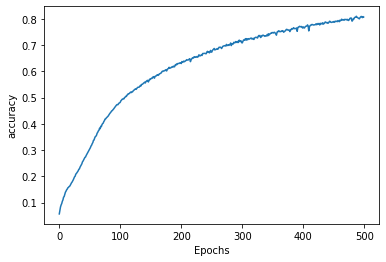

In [ ]:
plot_graphs(history, 'accuracy')

## Text Generation

I put the seed text as below. The model will generate 100 words after the seed text.

In [ ]:
seed_text = "I have some proposals to the Congress"
next_words = 100

In [ ]:
for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = model.predict_classes(token_list, verbose=0)
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word

print(seed_text)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
I have some proposals to the Congress presented 1947 that i have included in the people and the policy for a few days i have a month earlier resources in a rate of prices and wages which more permanently sustainable rates of the vast public debt and to check year improved services to sustained economic situation to deal with the situation points up generally i evaluate it should should i evaluate i deal show i evaluate wholesale control of our program among as of deflationary pressures of living through hospitals and to savings and credit wages prosperity to reduce of low incomes health or strikes soon as


Looks like English. Sounds like presidential?

My ambition was to create some A. I. Presidents, like a Democrat President or a Republican President, and let them talk about health care, tax, trade, etc. However, the generated texts so far are not convincing. 